<a href="https://colab.research.google.com/github/fabriziobasso/Colab_backup/blob/main/brist1d_blood_glucose_prediction_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrisT1D Blood Glucose Prediction with TabNet V0

In [ ]:
%%capture
!pip install -qq pytorch_tabnet
!!pip install optuna
!pip install optuna-integration-pytorch-tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = df_train[colset].interpolate(axis=1)
    df_test[colset] = df_test[colset].interpolate(axis=1)

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
imputer = SimpleImputer(strategy="mean")

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [ ]:
df_train[feature_cols].isna().sum()

,0
bg-0-00,0
bg-0-05,0
bg-0-10,0
bg-0-15,0
bg-0-20,0
...,...
cals-0-35,0
cals-0-40,0
cals-0-45,0
cals-0-50,0


## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,27254
bg-5-50,18491
bg-5-45,13660
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols]
y = df_train[[target_col]]
groups = df_train[group_col]
cv = GroupKFold(5)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

Fold 0
epoch 0  | loss: 6.85918 | val_0_rmse: 2.71554 |  0:00:07s
epoch 1  | loss: 4.24413 | val_0_rmse: 2.21357 |  0:00:14s


KeyboardInterrupt: 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

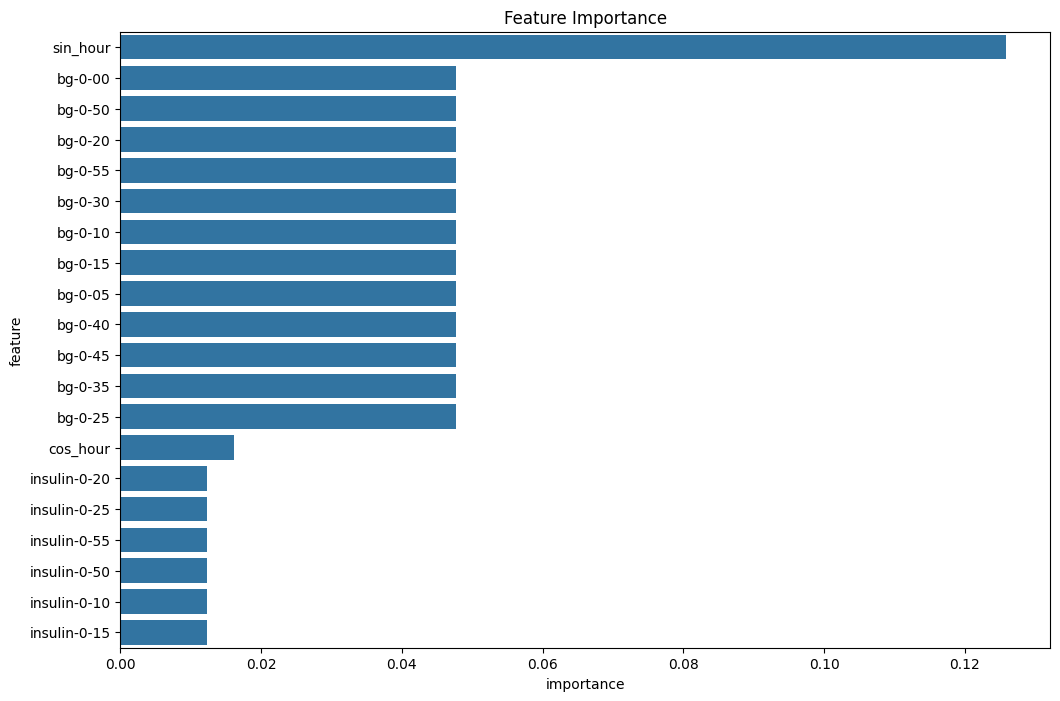

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.972011
p01_8460,5.830921
p01_8461,7.794858
p01_8462,10.844385
p01_8463,6.398709


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN
p01_1,NaN,NaN,NaN,12.762192,NaN
p01_2,NaN,NaN,NaN,12.50032,NaN
p01_3,NaN,NaN,NaN,12.799201,NaN
p01_4,NaN,NaN,NaN,12.184162,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.334588,NaN,13.334588
p01_1,NaN,NaN,NaN,12.762192,NaN,12.762192
p01_2,NaN,NaN,NaN,12.50032,NaN,12.50032
p01_3,NaN,NaN,NaN,12.799201,NaN,12.799201
p01_4,NaN,NaN,NaN,12.184162,NaN,12.184162


In [ ]:
oof_results.isna().sum()

,0
0,150996
1,142864
2,143187
3,143266
4,127783
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v0.csv")

# BrisT1D Blood Glucose Prediction with TabNet V1

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

#new_train = new_train[feature_cols]
new_train.shape

(36440, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,0
bg-5-50,0
bg-5-45,0
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

In [ ]:
# X.columns

# print(feature_cols)

X.head(3)#.isna().sum().sum()

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-35,cals-0-30,cals-0-25,cals-0-20,cals-0-15,cals-0-10,cals-0-05,cals-0-00,sin_hour,cos_hour
id,,,,,,,,,,,,,,,,,,,,,
p01_0,17.5,17.5,17.5,17.433333,17.366667,17.3,16.933333,16.566667,16.2,15.833333,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17
p01_1,17.3,17.3,17.3,16.933333,16.566667,16.2,15.833333,15.466667,15.1,14.866667,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17
p01_2,16.2,16.2,16.2,15.833333,15.466667,15.1,14.866667,14.633333,14.4,14.233333,...,9.223469,9.22133,9.224794,9.225912,9.224258,9.22529,9.222623,9.211014,1.0,6.123234e-17


In [ ]:
new_train[feature_cols].tail(3)

,bg-0-55,bg-0-50,bg-0-45,bg-0-40,bg-0-35,bg-0-30,bg-0-25,bg-0-20,bg-0-15,bg-0-10,...,cals-0-35,cals-0-30,cals-0-25,cals-0-20,cals-0-15,cals-0-10,cals-0-05,cals-0-00,sin_hour,cos_hour
36437,10.8,10.8,10.7,10.4,10.3,10.1,10.0,9.9,9.9,9.9,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,4.15,0.500000,0.866025
36438,7.9,8.0,7.9,7.8,7.7,7.7,7.6,7.5,7.5,7.2,...,4.15,4.15,4.15,4.15,4.15,4.15,4.15,4.15,0.965926,0.258819
36439,5.9,5.9,5.9,5.9,5.8,5.5,5.5,5.4,5.4,5.7,...,4.15,4.31,4.23,9.29,4.40,4.15,4.15,4.15,0.500000,0.866025


In [ ]:
#pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)

In [ ]:
# new_train.shape,X.shape
# plt.plot(y)

In [ ]:
X = df_train[feature_cols]
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(7)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v1/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].to_numpy()

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    i += 1

df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 7.13361 | val_0_rmse: 2.20941 |  0:00:09s


KeyboardInterrupt: 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

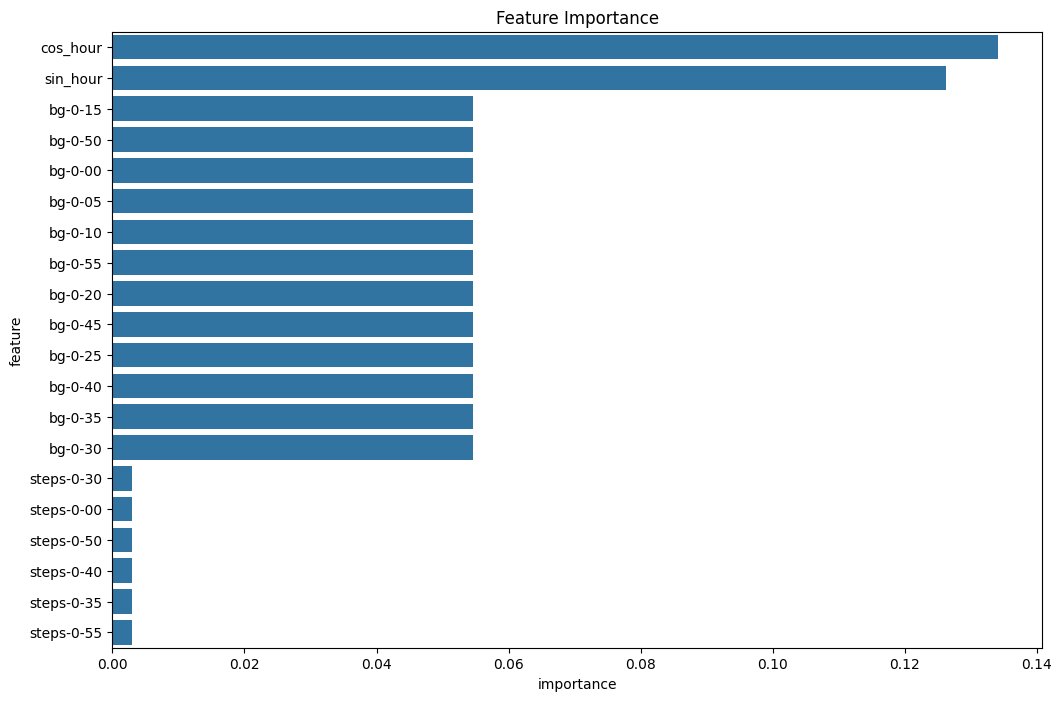

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.631357
p01_8460,6.126371
p01_8461,7.723211
p01_8462,10.624363
p01_8463,6.908243


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v1.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4
0,NaN,NaN,11.73698,NaN,NaN
1,NaN,NaN,11.303996,NaN,NaN
2,NaN,NaN,11.140917,NaN,NaN
3,NaN,NaN,11.685648,NaN,NaN
4,NaN,NaN,11.166823,NaN,NaN


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,average
0,NaN,NaN,11.73698,NaN,NaN,11.73698
1,NaN,NaN,11.303996,NaN,NaN,11.303996
2,NaN,NaN,11.140917,NaN,NaN,11.140917
3,NaN,NaN,11.685648,NaN,NaN,11.685648
4,NaN,NaN,11.166823,NaN,NaN,11.166823


In [ ]:
oof_results.isna().sum()

,0
0,172785
1,174599
2,172939
3,172862
4,160671
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v1.csv")

# BrisT1D Blood Glucose Prediction with TabNet V2

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['hr', 'cals', 'insulin', 'carbs', 'activity', 'bg', 'steps']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(10):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(36440, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

In [ ]:
df_train.isna().sum()

,0
p_num,0
time,0
bg-5-55,0
bg-5-50,0
bg-5-45,0
...,...
activity-0-05,174271
activity-0-00,174287
bg+1-00,0
sin_hour,0


## Training & Inference


In [ ]:
new_train

X = df_train[feature_cols]
y = df_train[[target_col]]

rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v2/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 8.13844 | val_0_rmse: 2.13293 |  0:00:10s
epoch 1  | loss: 4.63448 | val_0_rmse: 2.38744 |  0:00:20s
epoch 2  | loss: 4.53453 | val_0_rmse: 2.14449 |  0:00:31s
epoch 3  | loss: 4.44103 | val_0_rmse: 2.05799 |  0:00:41s
epoch 4  | loss: 4.40279 | val_0_rmse: 2.08979 |  0:00:51s
epoch 5  | loss: 4.3598  | val_0_rmse: 2.10855 |  0:01:01s
epoch 6  | loss: 4.3307  | val_0_rmse: 2.02228 |  0:01:12s
epoch 7  | loss: 4.30132 | val_0_rmse: 2.20839 |  0:01:23s
epoch 8  | loss: 4.28173 | val_0_rmse: 2.10069 |  0:01:34s
epoch 9  | loss: 4.26313 | val_0_rmse: 2.03755 |  0:01:44s
epoch 10 | loss: 4.23489 | val_0_rmse: 2.0477  |  0:01:55s
epoch 11 | loss: 4.22437 | val_0_rmse: 2.1466  |  0:02:05s
epoch 12 | loss: 4.19014 | val_0_rmse: 2.03621 |  0:02:16s
epoch 13 | loss: 4.16345 | val_0_rmse: 2.11344 |  0:02:26s
epoch 14 | loss: 4.14758 | val_0_rmse: 2.06566 |  0:02:37s
epoch 15 | loss: 4.11588 | val_0_rmse: 2.11265 |  0:02:48s
epoch 16 | loss: 4.13571 | val_0_rmse: 2.22966 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,9.007207
p01_8460,5.922358
p01_8461,8.111410
p01_8462,10.851858
p01_8463,7.251251


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v2.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,14.16102
1,NaN,NaN,NaN,NaN,NaN,NaN,13.622066
2,NaN,NaN,NaN,NaN,NaN,NaN,13.333781
3,NaN,NaN,NaN,NaN,NaN,NaN,13.562715
4,NaN,NaN,NaN,NaN,NaN,NaN,13.082964


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,5,6,average
0,NaN,NaN,NaN,NaN,NaN,NaN,14.16102,14.16102
1,NaN,NaN,NaN,NaN,NaN,NaN,13.622066,13.622066
2,NaN,NaN,NaN,NaN,NaN,NaN,13.333781,13.333781
3,NaN,NaN,NaN,NaN,NaN,NaN,13.562715,13.562715
4,NaN,NaN,NaN,NaN,NaN,NaN,13.082964,13.082964


In [ ]:
oof_results.isna().sum()

,0
0,182975
1,182962
2,183738
3,183740
4,184089
5,182486
6,180794
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v2.csv")

# BrisT1D Blood Glucose Prediction with TabNet V3&4

In [ ]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [ ]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [ ]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [ ]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [ ]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [ ]:
from datetime import timedelta

### Extract Additional Data:

In [ ]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [ ]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)
new_train['cos_hour'] = np.cos(np.pi * (new_train[date_col].dt.hour+(new_train[date_col].dt.minute/60)) / 12.92)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [ ]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [ ]:
df_train['sin_hour'] = np.sin(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)
df_train['cos_hour'] = np.cos(np.pi * (df_train[date_col].dt.hour+(df_train[date_col].dt.minute/60)) / 12.92)

df_test['sin_hour'] = np.sin(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)
df_test['cos_hour'] = np.cos(np.pi * (df_test[date_col].dt.hour+(df_test[date_col].dt.minute/60)) / 12.92)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [ ]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [ ]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

## Training & Inference


In [ ]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [ ]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 7

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features,
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v4/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 7.66855 | val_0_rmse: 2.13405 |  0:00:10s
epoch 1  | loss: 4.64557 | val_0_rmse: 2.08696 |  0:00:20s
epoch 2  | loss: 4.56179 | val_0_rmse: 2.06094 |  0:00:30s
epoch 3  | loss: 4.53967 | val_0_rmse: 2.04054 |  0:00:40s
epoch 4  | loss: 4.50344 | val_0_rmse: 1.99638 |  0:00:50s
epoch 5  | loss: 4.46169 | val_0_rmse: 2.01852 |  0:00:59s
epoch 6  | loss: 4.44673 | val_0_rmse: 2.13648 |  0:01:09s
epoch 7  | loss: 4.43144 | val_0_rmse: 2.03962 |  0:01:19s
epoch 8  | loss: 4.39539 | val_0_rmse: 2.04892 |  0:01:29s
epoch 9  | loss: 4.39543 | val_0_rmse: 2.04222 |  0:01:39s
epoch 10 | loss: 4.37592 | val_0_rmse: 2.0335  |  0:01:49s
epoch 11 | loss: 4.32558 | val_0_rmse: 2.12712 |  0:01:58s
epoch 12 | loss: 4.31204 | val_0_rmse: 2.08309 |  0:02:08s
epoch 13 | loss: 4.31422 | val_0_rmse: 2.10352 |  0:02:18s
epoch 14 | loss: 4.33325 | val_0_rmse: 2.09315 |  0:02:28s
epoch 15 | loss: 4.28492 | val_0_rmse: 2.04128 |  0:02:38s
epoch 16 | loss: 4.2945  | val_0_rmse: 2.04481 | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

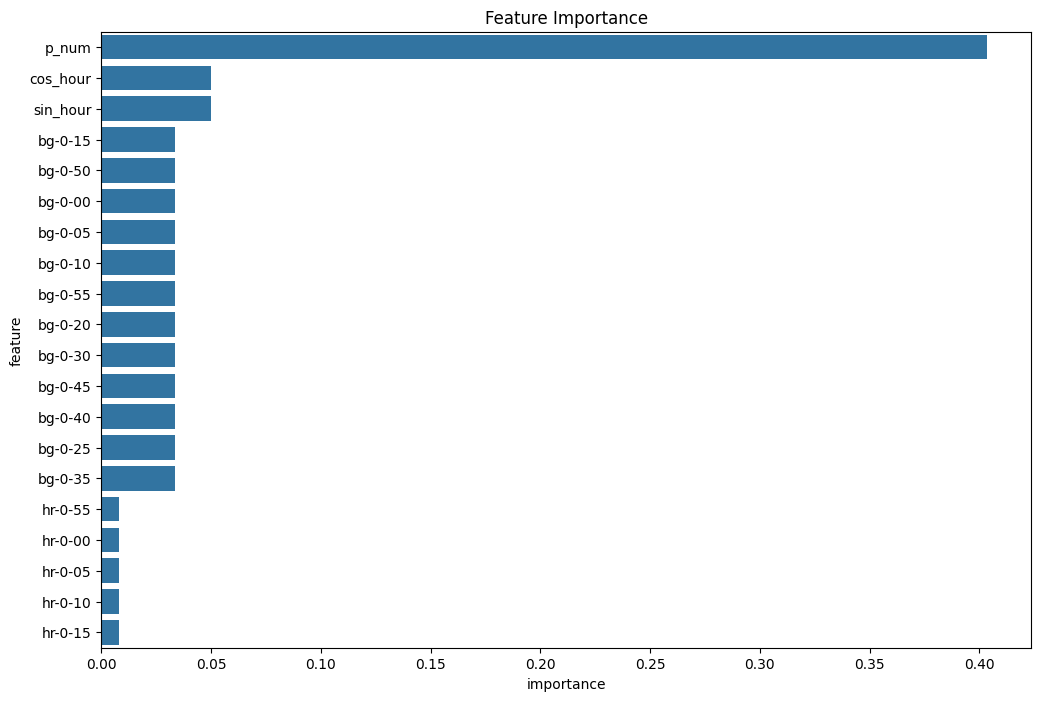

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
df_train.reset_index(inplace=True, drop=True)

In [250]:
import optuna
from sklearn.metrics import mean_squared_error

X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

def objective(trial,FOLDS=3):
    """
    Objective function for Optuna to optimize TabNetRegressor hyperparameters.

    Args:
        trial: Optuna trial object.
        X: Feature matrix.
        y: Target variable.
        n_splits: Number of cross-validation splits.

    Returns:
        float: Mean cross-validated RMSE.
    """

    # Suggest hyperparameters using Optuna's trial object
    params = {
        "n_d": trial.suggest_int("n_d", 8, 16, step=2),
        "n_a": trial.suggest_int("n_a", 8, 16, step=2),
        "n_steps": trial.suggest_int("n_steps", 3, 5),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "verbose": 0,  # Suppress verbose output during optimization
    }

    # K-fold cross-validation
    kf = GroupKFold(FOLDS)
    rmse_scores = []

    for train_index, val_index in kf.split(X, y, groups=groups):
        X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
        X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

        # Create and train the TabNet model
        model = TabNetRegressor(grouped_features=grouped_features, **params)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=["rmse"],
            max_epochs=15,  # You might need to adjust this
            patience=5,  # Early stopping patience
        )

        # Make predictions and evaluate
        y_pred = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)  # Return the mean RMSE across folds


# --- Example usage ---
# Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# Create an Optuna study
study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# Optimize the objective function
study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# Get the best parameters and results
best_params = study.best_params
best_rmse = study.best_value

print(f"Best RMSE: {best_rmse:.4f}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

[I 2024-11-25 22:46:21,466] A new study created in memory with name: tabnet_tuning



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957


[I 2024-11-25 22:52:02,332] Trial 0 finished with value: 2.459570272548515 and parameters: {'n_d': 12, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3490784113575338, 'lambda_sparse': 8.471568555451309e-05}. Best is trial 0 with value: 2.459570272548515.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209


[I 2024-11-25 22:56:57,168] Trial 1 finished with value: 2.4120854038520774 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.3041222166061175, 'lambda_sparse': 3.957685023182555e-05}. Best is trial 1 with value: 2.4120854038520774.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257


[I 2024-11-25 23:07:53,770] Trial 2 finished with value: 2.392569259528497 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7445943523450596, 'lambda_sparse': 0.006331983758155842}. Best is trial 2 with value: 2.392569259528497.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149


[I 2024-11-25 23:16:54,938] Trial 3 finished with value: 2.391493871510805 and parameters: {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254


[I 2024-11-25 23:25:21,099] Trial 4 finished with value: 2.392541915969973 and parameters: {'n_d': 10, 'n_a': 12, 'n_steps': 5, 'gamma': 1.6501876075101474, 'lambda_sparse': 0.0004364114571650071}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072


[I 2024-11-25 23:30:55,705] Trial 5 finished with value: 2.450718169171711 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.2693171006163841, 'lambda_sparse': 5.415085169273254e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671


[I 2024-11-25 23:35:55,197] Trial 6 finished with value: 2.476707663252563 and parameters: {'n_d': 14, 'n_a': 10, 'n_steps': 3, 'gamma': 1.324547021628604, 'lambda_sparse': 4.4140005941474256e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115


[I 2024-11-25 23:46:38,729] Trial 7 finished with value: 2.43114977088551 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.6665271706474591, 'lambda_sparse': 0.008379302367947563}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588


[I 2024-11-25 23:57:09,759] Trial 8 finished with value: 2.395875326379685 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.4043390302148786, 'lambda_sparse': 7.579749177032064e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878


[I 2024-11-26 00:05:16,423] Trial 9 finished with value: 2.4287805008465173 and parameters: {'n_d': 10, 'n_a': 14, 'n_steps': 4, 'gamma': 1.826027275212689, 'lambda_sparse': 7.054854384682835e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_rmse = 2.3977


[W 2024-11-26 00:08:58,300] Trial 10 failed with parameters: {'n_d': 12, 'n_a': 12, 'n_steps': 3, 'gamma': 1.0087237559084916, 'lambda_sparse': 0.0007123742377882674} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-250-fc6b05ef4915>", line 73, in <lambda>
    study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials
  File "<ipython-input-250-fc6b05ef4915>", line 49, in objective
    model.fit(
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 258, in fit
    self._train_epoch(train_dataloader)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 489, in _train_epoch
    batch_logs = self._train_batch(X, y)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py", line 534, 

KeyboardInterrupt: 

## Save Results:

In [ ]:
df_subm.head()

,bg+1:00
id,
p01_8459,8.682322
p01_8460,6.385798
p01_8461,7.867571
p01_8462,10.428039
p01_8463,6.939459


In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v4.csv')

In [ ]:
oof_results.head()

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,11.174798
1,NaN,NaN,NaN,NaN,NaN,NaN,10.628863
2,NaN,NaN,NaN,NaN,NaN,NaN,10.553446
3,NaN,NaN,NaN,NaN,NaN,NaN,11.087376
4,NaN,NaN,NaN,NaN,NaN,NaN,10.675967


In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

,0,1,2,3,4,5,6,average
0,NaN,NaN,NaN,NaN,NaN,NaN,11.174798,11.174798
1,NaN,NaN,NaN,NaN,NaN,NaN,10.628863,10.628863
2,NaN,NaN,NaN,NaN,NaN,NaN,10.553446,10.553446
3,NaN,NaN,NaN,NaN,NaN,NaN,11.087376,11.087376
4,NaN,NaN,NaN,NaN,NaN,NaN,10.675967,10.675967


In [ ]:
oof_results.isna().sum()

,0
0,214225
1,214772
2,215138
3,215910
4,215709
5,210813
6,212857
average,0


In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v4.csv")

# BrisT1D Blood Glucose Prediction with TabNet V5

In [331]:
!pip install -qq pytorch_tabnet

from pytorch_tabnet.tab_model import TabNetRegressor

In [332]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [333]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [334]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [335]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [336]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [337]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [338]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [339]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [340]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [341]:
from datetime import timedelta

### Extract Additional Data:

In [342]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [343]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [344]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [345]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Grouped Features
It is possible to specify attention groups (using grouped_features). Attention is done at the group level and not feature level. This is especially useful if a dataset has a lot of columns coming from on single source of data

In [346]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols, static, time_group]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [347]:
grouped_features

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72],
 [73, 74]]

## Training & Inference


In [348]:
new_train

X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [349]:
# X.columns

# print(feature_cols)

X.isna().sum().sum()

0

In [ ]:
X = df_train[feature_cols].copy()
X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
y = df_train[[target_col]]
y = pd.concat([y, new_target], axis=0, ignore_index=True)
FOLDS = 5

X["p_num"].replace(rep_dict, inplace=True)

groups_0 = df_train[group_col]
groups_1 = new_train[group_col]
groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

cv = GroupKFold(FOLDS)
df_subm['bg+1:00'] = 0.0
i=0

oof_results = pd.DataFrame(columns=list(range(FOLDS)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Initialize the TabNet Regressor model
    params = {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}
    reg = TabNetRegressor(
        grouped_features=grouped_features,**params
    )

    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
        max_epochs=100,
        patience=15,
    )

    torch.save(reg, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/Tabnet_v4/tabnet_model_{i}.pth")

    tab_preds = reg.predict(X_valid)

    oof_results.iloc[idx_valid,i] = tab_preds.flatten()
    # Prepare the test data and make predictions
    X_test = df_test[feature_cols].copy()
    X_test["p_num"].replace(rep_dict, inplace=True)
    X_test = X_test.to_numpy()


    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / FOLDS
    i += 1

#df_subm.to_csv('submission_tabnet.csv')

Fold 0
epoch 0  | loss: 6.79229 | val_0_rmse: 2.65812 |  0:00:13s
epoch 1  | loss: 4.81072 | val_0_rmse: 2.04179 |  0:00:26s
epoch 2  | loss: 4.70195 | val_0_rmse: 1.92314 |  0:00:38s
epoch 3  | loss: 4.65515 | val_0_rmse: 2.37151 |  0:00:50s
epoch 4  | loss: 4.62349 | val_0_rmse: 2.00575 |  0:01:02s
epoch 5  | loss: 4.66619 | val_0_rmse: 2.08927 |  0:01:14s
epoch 6  | loss: 4.59451 | val_0_rmse: 2.09711 |  0:01:26s
epoch 7  | loss: 4.5299  | val_0_rmse: 2.11327 |  0:01:38s
epoch 8  | loss: 4.53506 | val_0_rmse: 2.00187 |  0:01:50s
epoch 9  | loss: 4.52018 | val_0_rmse: 1.98511 |  0:02:02s
epoch 10 | loss: 4.49681 | val_0_rmse: 2.03496 |  0:02:14s
epoch 11 | loss: 4.46704 | val_0_rmse: 1.93308 |  0:02:26s
epoch 12 | loss: 4.4256  | val_0_rmse: 1.92761 |  0:02:38s
epoch 13 | loss: 4.40532 | val_0_rmse: 1.94562 |  0:02:50s
epoch 14 | loss: 4.38931 | val_0_rmse: 2.0     |  0:03:03s
epoch 15 | loss: 4.38456 | val_0_rmse: 1.91402 |  0:03:14s
epoch 16 | loss: 4.34856 | val_0_rmse: 1.9444  | 

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Feature Importance</h3>
</div>

In [ ]:
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20],
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

### Model Hyperparameter Tuning:

In [ ]:
# df_train.reset_index(inplace=True, drop=True)

In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_error

# X = df_train[feature_cols].copy()
# X = pd.concat([X, new_train[feature_cols]], axis=0, ignore_index=True)
# y = df_train[[target_col]]
# y = pd.concat([y, new_target], axis=0, ignore_index=True)

# X["p_num"].replace(rep_dict, inplace=True)

# groups_0 = df_train[group_col]
# groups_1 = new_train[group_col]
# groups = pd.concat([groups_0, groups_1], axis=0, ignore_index=True)

# def objective(trial,FOLDS=3):
#     """
#     Objective function for Optuna to optimize TabNetRegressor hyperparameters.

#     Args:
#         trial: Optuna trial object.
#         X: Feature matrix.
#         y: Target variable.
#         n_splits: Number of cross-validation splits.

#     Returns:
#         float: Mean cross-validated RMSE.
#     """

#     # Suggest hyperparameters using Optuna's trial object
#     params = {
#         "n_d": trial.suggest_int("n_d", 8, 16, step=2),
#         "n_a": trial.suggest_int("n_a", 8, 16, step=2),
#         "n_steps": trial.suggest_int("n_steps", 3, 5),
#         "gamma": trial.suggest_float("gamma", 1.0, 2.0),
#         "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
#         "verbose": 0,  # Suppress verbose output during optimization
#     }

#     # K-fold cross-validation
#     kf = GroupKFold(FOLDS)
#     rmse_scores = []

#     for train_index, val_index in kf.split(X, y, groups=groups):
#         X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
#         X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

#         # Create and train the TabNet model
#         model = TabNetRegressor(grouped_features=grouped_features, **params)
#         model.fit(
#             X_train=X_train,
#             y_train=y_train,
#             eval_set=[(X_valid, y_valid)],
#             eval_metric=["rmse"],
#             max_epochs=15,  # You might need to adjust this
#             patience=5,  # Early stopping patience
#         )

#         # Make predictions and evaluate
#         y_pred = model.predict(X_valid)
#         rmse = mean_squared_error(y_valid, y_pred, squared=False)
#         rmse_scores.append(rmse)

#     return np.mean(rmse_scores)  # Return the mean RMSE across folds


# # --- Example usage ---
# # Assuming you have your data loaded as X and y (NumPy arrays or Pandas DataFrames)

# # Create an Optuna study
# study = optuna.create_study(direction="minimize", study_name="tabnet_tuning")

# # Optimize the objective function
# study.optimize(lambda trial: objective(trial), n_trials=100)  # Adjust n_trials

# # Get the best parameters and results
# best_params = study.best_params
# best_rmse = study.best_value

# print(f"Best RMSE: {best_rmse:.4f}")
# print("Best hyperparameters:")
# for key, value in best_params.items():
#     print(f"  {key}: {value}")

[I 2024-11-25 22:46:21,466] A new study created in memory with name: tabnet_tuning



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.45957


[I 2024-11-25 22:52:02,332] Trial 0 finished with value: 2.459570272548515 and parameters: {'n_d': 12, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3490784113575338, 'lambda_sparse': 8.471568555451309e-05}. Best is trial 0 with value: 2.459570272548515.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.41209


[I 2024-11-25 22:56:57,168] Trial 1 finished with value: 2.4120854038520774 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.3041222166061175, 'lambda_sparse': 3.957685023182555e-05}. Best is trial 1 with value: 2.4120854038520774.



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_rmse = 2.39257


[I 2024-11-25 23:07:53,770] Trial 2 finished with value: 2.392569259528497 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7445943523450596, 'lambda_sparse': 0.006331983758155842}. Best is trial 2 with value: 2.392569259528497.



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_rmse = 2.39149


[I 2024-11-25 23:16:54,938] Trial 3 finished with value: 2.391493871510805 and parameters: {'n_d': 12, 'n_a': 10, 'n_steps': 3, 'gamma': 1.3760921662808248, 'lambda_sparse': 0.0015459917383043482}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 2.39254


[I 2024-11-25 23:25:21,099] Trial 4 finished with value: 2.392541915969973 and parameters: {'n_d': 10, 'n_a': 12, 'n_steps': 5, 'gamma': 1.6501876075101474, 'lambda_sparse': 0.0004364114571650071}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_rmse = 2.45072


[I 2024-11-25 23:30:55,705] Trial 5 finished with value: 2.450718169171711 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.2693171006163841, 'lambda_sparse': 5.415085169273254e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_rmse = 2.47671


[I 2024-11-25 23:35:55,197] Trial 6 finished with value: 2.476707663252563 and parameters: {'n_d': 14, 'n_a': 10, 'n_steps': 3, 'gamma': 1.324547021628604, 'lambda_sparse': 4.4140005941474256e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.43115


[I 2024-11-25 23:46:38,729] Trial 7 finished with value: 2.43114977088551 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.6665271706474591, 'lambda_sparse': 0.008379302367947563}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_rmse = 2.39588


[I 2024-11-25 23:57:09,759] Trial 8 finished with value: 2.395875326379685 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 4, 'gamma': 1.4043390302148786, 'lambda_sparse': 7.579749177032064e-05}. Best is trial 3 with value: 2.391493871510805.



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_rmse = 2.42878


## Save Results:

In [ ]:
df_subm.head()

In [ ]:
df_subm.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v5.csv')

In [ ]:
oof_results.head()

In [ ]:
oof_results["average"] = oof_results.mean(axis=1)
oof_results.head()

In [ ]:
oof_results.isna().sum()

In [ ]:
train_results_df_ = oof_results["average"].astype("float").copy()
train_results_df_.columns = ["bg+1:tabnetv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_tabnet_v5.csv")

# BrisT1D Blood Glucose Prediction with StackedRegressor V0

In [ ]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [ ]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = "bg+1-00"  # Target column name for prediction
group_col = "p_num"  # Column name for grouping (e.g., participant number)
date_col = "time"  # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols = [f"bg-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
insu_cols = [f"insulin-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
carb_cols = [f"carbs-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
hr_cols = [f"hr-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
step_cols = [f"steps-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]
cals_cols = [f"cals-{i}-{j:02d}" for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [ ]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [ ]:
import random
import os
import numpy as np
import torch


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
seed = 43  #
Thr_NAN = 49
seed_everything(seed)

In [ ]:
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(":", "-")
df_test.columns = df_test.columns.str.replace(":", "-")


for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="bfill", axis=1)
        .fillna(method="ffill", axis=1)
    )

In [ ]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['hr', 'cals', 'insulin', 'carbs', 'activity', 'bg', 'steps']

In [ ]:
mask = df_train[feature_cols].isna().sum(axis=1) <= Thr_NAN
# Apply the mask to filter the rows
df_train = df_train[mask]


imputer = SimpleImputer()

df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

In [304]:
df_train["sin_hour"] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train["cos_hour"] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test["sin_hour"] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test["cos_hour"] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(["sin_hour", "cos_hour"])


grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)


df_train_final = df_train[feature_cols]
groups = df_train[group_col]

y_target = df_train[[target_col]]

df_test_final = df_test[feature_cols]

In [ ]:
df_train_final.columns

Index(['bg-0-00', 'bg-0-05', 'bg-0-10', 'bg-0-15', 'bg-0-20', 'bg-0-25',
       'bg-0-30', 'bg-0-35', 'bg-0-40', 'bg-0-45', 'bg-0-50', 'bg-0-55',
       'insulin-0-00', 'insulin-0-05', 'insulin-0-10', 'insulin-0-15',
       'insulin-0-20', 'insulin-0-25', 'insulin-0-30', 'insulin-0-35',
       'insulin-0-40', 'insulin-0-45', 'insulin-0-50', 'insulin-0-55',
       'carbs-0-00', 'carbs-0-05', 'carbs-0-10', 'carbs-0-15', 'carbs-0-20',
       'carbs-0-25', 'carbs-0-30', 'carbs-0-35', 'carbs-0-40', 'carbs-0-45',
       'carbs-0-50', 'carbs-0-55', 'hr-0-00', 'hr-0-05', 'hr-0-10', 'hr-0-15',
       'hr-0-20', 'hr-0-25', 'hr-0-30', 'hr-0-35', 'hr-0-40', 'hr-0-45',
       'hr-0-50', 'hr-0-55', 'steps-0-00', 'steps-0-05', 'steps-0-10',
       'steps-0-15', 'steps-0-20', 'steps-0-25', 'steps-0-30', 'steps-0-35',
       'steps-0-40', 'steps-0-45', 'steps-0-50', 'steps-0-55', 'cals-0-00',
       'cals-0-05', 'cals-0-10', 'cals-0-15', 'cals-0-20', 'cals-0-25',
       'cals-0-30', 'cals-0-35', 'cals-

In [303]:
df_train_final.columns

NameError: name 'df_train_final' is not defined

## Train the Model:

In [ ]:
%%capture
!pip install skops
!pip install catboost

In [ ]:
import skops.io as sio

In [ ]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

X_test = df_test_final.to_numpy()

groups = df_train[group_col]
cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v2_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8643085	total: 10.7s	remaining: 21.4s
1002:	learn: 1.8641442	total: 10.7s	remaining: 21.4s
1003:	learn: 1.8640122	total: 10.8s	remaining: 21.4s
1004:	learn: 1.8638137	total: 10.8s	remaining: 21.4s
1005:	learn: 1.8637006	total: 10.8s	remaining: 21.4s
1006:	learn: 1.8635742	total: 10.8s	remaining: 21.3s
1007:	learn: 1.8633916	total: 10.8s	remaining: 21.3s
1008:	learn: 1.8632438	total: 10.8s	remaining: 21.3s
1009:	learn: 1.8631322	total: 10.8s	remaining: 21.3s
1010:	learn: 1.8629973	total: 10.8s	remaining: 21.3s
1011:	learn: 1.8628029	total: 10.8s	remaining: 21.3s
1012:	learn: 1.8626712	total: 10.8s	remaining: 21.3s
1013:	learn: 1.8625340	total: 10.9s	remaining: 21.3s
1014:	learn: 1.8624135	total: 10.9s	remaining: 21.3s
1015:	learn: 1.8622388	total: 10.9s	remaining: 21.2s
1016:	learn: 1.8620770	total: 10.9s	remaining: 21.2s
1017:	learn: 1.8619116	total: 10.9s	remaining: 21.2s
1018:	learn: 1.8618258	total: 10.9s	remaining: 2

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN
p01_1,NaN,NaN,NaN,12.638141,NaN
p01_2,NaN,NaN,NaN,12.835038,NaN
p01_3,NaN,NaN,NaN,13.330393,NaN
p01_4,NaN,NaN,NaN,12.495023,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN,13.076592
p01_1,NaN,NaN,NaN,12.638141,NaN,12.638141
p01_2,NaN,NaN,NaN,12.835038,NaN,12.835038
p01_3,NaN,NaN,NaN,13.330393,NaN,13.330393
p01_4,NaN,NaN,NaN,12.495023,NaN,12.495023


In [ ]:
oof_results_stack.isna().sum()

,0
0,149462
1,141441
2,141674
3,141732
4,127651
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v0.csv")

In [ ]:
tab = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
stack = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv', index_col='id')

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444
...,...
p24_256,6.563980
p24_257,9.650507
p24_258,7.268640


In [ ]:
ensemble_v0 = (tab+stack)/2

In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v0.csv')

# BrisT1D Blood Glucose Prediction with StackedRegressor V1

In [305]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer, KNNImputer
import warnings

# Import necessary libraries
from sklearn.linear_model import Ridge  # Meta-learner
from sklearn.ensemble import StackingRegressor
warnings.filterwarnings("ignore")

In [306]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [307]:
torch.__version__

'2.5.1+cu121'

## Data Variables


In [308]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)
date_col = 'time'      # Column name for time data

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12][::-1]

static = [group_col]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols + static

<div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Loading and Preprocessing Data for Compatibility</h3>
</div>


In [309]:
df_train = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/train.csv',
    index_col='id',
    parse_dates=['time'],
)

df_test = pd.read_csv(
    '/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/test.csv',
    index_col='id',
    parse_dates=['time'],
)

df_subm = pd.read_csv(
    "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/sample_submission.csv",
    index_col='id',
)

# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

## Interpolation Imputing

Apply linear interpolation to fill missing values within each time series (e.g., blood glucose, insulin, etc.)


In [310]:
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    df_train[colset] = (
        df_train[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )
    df_test[colset] = (
        df_test[colset]
        .interpolate(axis=1)
        .fillna(method="ffill", axis=1)
        .fillna(method="bfill", axis=1)
    )

In [311]:
df_train["bg-5-55"][0]

nan

<div style="text-align:left; border-radius:15px; padding:15px; margin:0; font-size:100%; font-family:Arial, sans-serif; background-color:#A8DADC; color:#1D3557; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.2);">
    <h3>Mean Imputing</h3>
    <div style="text-align:left; font-size:100%; margin-top:5px;">This fits the imputer on the training data and fills missing values with the mean value</div>
</div>


In [312]:
activity_cols = df_test.filter(regex="activity").columns.to_list()
col_imputer = df_train.drop(columns=["p_num","time",'bg+1-00']+activity_cols).columns.to_list()

imputer = SimpleImputer(strategy="mean")

df_train[col_imputer] = imputer.fit_transform(df_train[col_imputer])
df_test[col_imputer] = imputer.transform(df_test[col_imputer])

In [313]:
macro_groups = list({q[:-5] for q in df_test.columns.to_list()})[1:]
macro_groups

['steps', 'carbs', 'activity', 'insulin', 'cals', 'hr', 'bg']

In [314]:
#df_test[df_test.filter(regex=macro_groups[5]).columns.to_list()[-1]]

In [315]:
from datetime import timedelta

### Extract Additional Data:

In [316]:
new_train = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target = pd.DataFrame(columns=[target_col])
new_train_temp = pd.DataFrame(columns=df_train[feature_cols].columns)
new_target_temp = pd.DataFrame(columns=[target_col])

for j in range(20):

  for i in range(len(macro_groups)):
    new_train_temp[df_test.filter(regex=macro_groups[i]).columns.to_list()[-12:]] = df_test[df_test.filter(regex=macro_groups[i]).columns.to_list()[-24-j:-12-j]]
    new_train_temp[group_col] = df_test[group_col]
    new_train_temp[date_col] = df_test[date_col] - timedelta(hours=1, minutes=j)
    new_target_temp[target_col] = df_test[df_test.filter(regex="bg").columns.to_list()[-1-j]]

  new_train = pd.concat([new_train, new_train_temp], axis=0)
  new_target = pd.concat([new_target, new_target_temp], axis=0)


new_train.reset_index(drop=True, inplace=True)
new_target.reset_index(drop=True, inplace=True)

In [317]:
new_train.filter(regex=macro_groups[5])
new_train[date_col]#.info()

new_train['sin_hour'] = np.sin(np.pi * new_train[date_col].dt.hour / 12)
new_train['cos_hour'] = np.cos(np.pi * new_train[date_col].dt.hour / 12)

time_group = ['sin_hour', 'cos_hour']
#new_train = new_train[feature_cols]
new_train.shape

(72880, 88)

In [318]:
df_train.shape

(177024, 507)

## Time Features
Create cyclic time features using sine and cosine transformations for the 'hour' component of the date column
This helps encode the hour of the day in a way that captures its cyclical nature (e.g., 23:00 is close to 00:00)

In [319]:
df_train['sin_hour'] = np.sin(np.pi * df_train[date_col].dt.hour / 12)
df_train['cos_hour'] = np.cos(np.pi * df_train[date_col].dt.hour / 12)

df_test['sin_hour'] = np.sin(np.pi * df_test[date_col].dt.hour / 12)
df_test['cos_hour'] = np.cos(np.pi * df_test[date_col].dt.hour / 12)

feature_cols.extend(['sin_hour', 'cos_hour'])

## Training & Inference


In [320]:
X_ = df_train[feature_cols]
y = df_train[[target_col]]
rep_dict = dict(zip(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'],list(range(len(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
        'p16', 'p18', 'p19', 'p21', 'p22', 'p24'])))))

In [321]:
X.columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [322]:
new_train[feature_cols].columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10', 'bg-0-05', 'bg-0-00',
       'insulin-0-55', 'insulin-0-50', 'insulin-0-45', 'insulin-0-40',
       'insulin-0-35', 'insulin-0-30', 'insulin-0-25', 'insulin-0-20',
       'insulin-0-15', 'insulin-0-10', 'insulin-0-05', 'insulin-0-00',
       'carbs-0-55', 'carbs-0-50', 'carbs-0-45', 'carbs-0-40', 'carbs-0-35',
       'carbs-0-30', 'carbs-0-25', 'carbs-0-20', 'carbs-0-15', 'carbs-0-10',
       'carbs-0-05', 'carbs-0-00', 'hr-0-55', 'hr-0-50', 'hr-0-45', 'hr-0-40',
       'hr-0-35', 'hr-0-30', 'hr-0-25', 'hr-0-20', 'hr-0-15', 'hr-0-10',
       'hr-0-05', 'hr-0-00', 'steps-0-55', 'steps-0-50', 'steps-0-45',
       'steps-0-40', 'steps-0-35', 'steps-0-30', 'steps-0-25', 'steps-0-20',
       'steps-0-15', 'steps-0-10', 'steps-0-05', 'steps-0-00', 'cals-0-55',
       'cals-0-50', 'cals-0-45', 'cals-0-40', 'cals-0-35', 'cals-0-30',
       'cals-0-25', 'cals-0-20', 'cals-

In [329]:
df_train_final = pd.concat([df_train[feature_cols], new_train[feature_cols]], axis=0)
y_target = pd.concat([df_train[[target_col]], new_target], axis=0)

df_train_final.shape, y_target.shape

((249904, 75), (249904, 1))

## Train the Model:

In [326]:
%%capture
!pip install skops
!pip install catboost
!pip install category-encoders

In [327]:
import skops.io as sio
import category_encoders as ce

In [330]:
df_subm_stack = df_subm.copy()

In [ ]:
# Meta-learner

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Define a common random seed for reproducibility
RANDOM_SEED = 42
N_ESTIMATORS = 3000  # Number of estimators for the ensemble models

X = df_train_final.copy()
y = y_target.copy()

encoder_ = ce.TargetEncoder()
X["p_num"] = encoder_.fit_transform(X["p_num"], y)
X_test["p_num"] = encoder_.transform(X_test["p_num"])

X_test = df_test_final.to_numpy()

groups = df_train[group_col]
cv = GroupKFold(5)
df_subm_stack['bg+1:00'] = 0.0

i=0

oof_results_stack = pd.DataFrame(columns=list(range(5)), index=X.index)

for idx_train, idx_valid in cv.split(X, y, groups=groups):

    print(f"Fold {i}")

    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()

    # Define base estimators with random seed and number of estimators
    estimators = [
        ('lgbm', LGBMRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS,subsample=0.9, colsample_bytree=0.95)),
        ('xgb', XGBRegressor(random_state=RANDOM_SEED, n_estimators=N_ESTIMATORS, colsample_bytree = 0.95, subsample= 0.90)),
        ('catboost', CatBoostRegressor(random_seed=RANDOM_SEED, iterations=N_ESTIMATORS, subsample=0.9))
    ]

    meta_model = Ridge(alpha=0.1)

    # Create StackingRegressor
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=meta_model)

    # Fit the StackingRegressor
    stacking_model.fit(X_train, y_train)
    obj = sio.dump(stacking_model, f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/Glucose/staked_v3_{i}.skops")

    stack_preds = stacking_model.predict(X_valid)

    oof_results_stack.iloc[idx_valid,i] = stack_preds.flatten()
    # Prepare the test data and make predictions

    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm_stack['bg+1:00'] += stacking_model.predict(X_test) / 5
    i += 1

Streaming output truncated to the last 5000 lines.
1001:	learn: 1.8643085	total: 10.7s	remaining: 21.4s
1002:	learn: 1.8641442	total: 10.7s	remaining: 21.4s
1003:	learn: 1.8640122	total: 10.8s	remaining: 21.4s
1004:	learn: 1.8638137	total: 10.8s	remaining: 21.4s
1005:	learn: 1.8637006	total: 10.8s	remaining: 21.4s
1006:	learn: 1.8635742	total: 10.8s	remaining: 21.3s
1007:	learn: 1.8633916	total: 10.8s	remaining: 21.3s
1008:	learn: 1.8632438	total: 10.8s	remaining: 21.3s
1009:	learn: 1.8631322	total: 10.8s	remaining: 21.3s
1010:	learn: 1.8629973	total: 10.8s	remaining: 21.3s
1011:	learn: 1.8628029	total: 10.8s	remaining: 21.3s
1012:	learn: 1.8626712	total: 10.8s	remaining: 21.3s
1013:	learn: 1.8625340	total: 10.9s	remaining: 21.3s
1014:	learn: 1.8624135	total: 10.9s	remaining: 21.3s
1015:	learn: 1.8622388	total: 10.9s	remaining: 21.2s
1016:	learn: 1.8620770	total: 10.9s	remaining: 21.2s
1017:	learn: 1.8619116	total: 10.9s	remaining: 21.2s
1018:	learn: 1.8618258	total: 10.9s	remaining: 2

## Save Results:

In [ ]:
df_subm_stack.head()

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444


In [ ]:
df_subm_stack.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v3.csv')

In [ ]:
oof_results_stack.head()

,0,1,2,3,4
id,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN
p01_1,NaN,NaN,NaN,12.638141,NaN
p01_2,NaN,NaN,NaN,12.835038,NaN
p01_3,NaN,NaN,NaN,13.330393,NaN
p01_4,NaN,NaN,NaN,12.495023,NaN


In [ ]:
oof_results_stack["average"] = oof_results_stack.mean(axis=1)
oof_results_stack.head()

,0,1,2,3,4,average
id,,,,,,
p01_0,NaN,NaN,NaN,13.076592,NaN,13.076592
p01_1,NaN,NaN,NaN,12.638141,NaN,12.638141
p01_2,NaN,NaN,NaN,12.835038,NaN,12.835038
p01_3,NaN,NaN,NaN,13.330393,NaN,13.330393
p01_4,NaN,NaN,NaN,12.495023,NaN,12.495023


In [ ]:
oof_results_stack.isna().sum()

,0
0,149462
1,141441
2,141674
3,141732
4,127651
average,0


In [ ]:
train_results_df_ = oof_results_stack["average"].astype("float").copy()
train_results_df_.columns = ["bg+1_stackv0_exp"]
train_results_df_.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/train_results_stack_v3.csv")

In [ ]:
tab = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_tabnet_v0.csv', index_col='id')
stack = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_stack_v0.csv', index_col='id')

,bg+1:00
id,
p01_8459,8.968587
p01_8460,5.779265
p01_8461,8.093807
p01_8462,10.604852
p01_8463,7.044444
...,...
p24_256,6.563980
p24_257,9.650507
p24_258,7.268640


In [ ]:
ensemble_v0 = (tab+stack)/2

In [ ]:
ensemble_v0.to_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/Glucose/submissions/submission_ensemble_v0.csv')